In [1]:
import re
import pandas as pd
from xml.sax.handler import feature_string_interning
from sklearn import datasets

df = pd.read_csv('glass.csv')

ekes = df.drop("Type", axis = 1)
y = df["Type"]

feature_names = df.columns.values
target_names = ["A", "B", "C", "D", "E", "F", "G"]

print(feature_names)
print(ekes)
print(y)


['RI' 'Na' 'Mg' 'Al' 'Si' 'K' 'Ca' 'Ba' 'Fe' 'Type']
          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0
..       ...    ...   ...   ...    ...   ...   ...   ...  ...
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0

[214 rows x 9 columns]
0      1
1      1
2      1
3      1
4      1
      ..
209    7
210    7
211    7
212    7
213    7
Name: Type, Length: 214, dtype: int64


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

max_depth = 3
model = DecisionTreeClassifier(max_depth = max_depth)
model.fit(ekes, y)
pred = model.predict(ekes)
print(accuracy_score(y, pred))

0.719626168224299


<bound method Figure.show of <Figure size 1800x1440 with 1 Axes>>

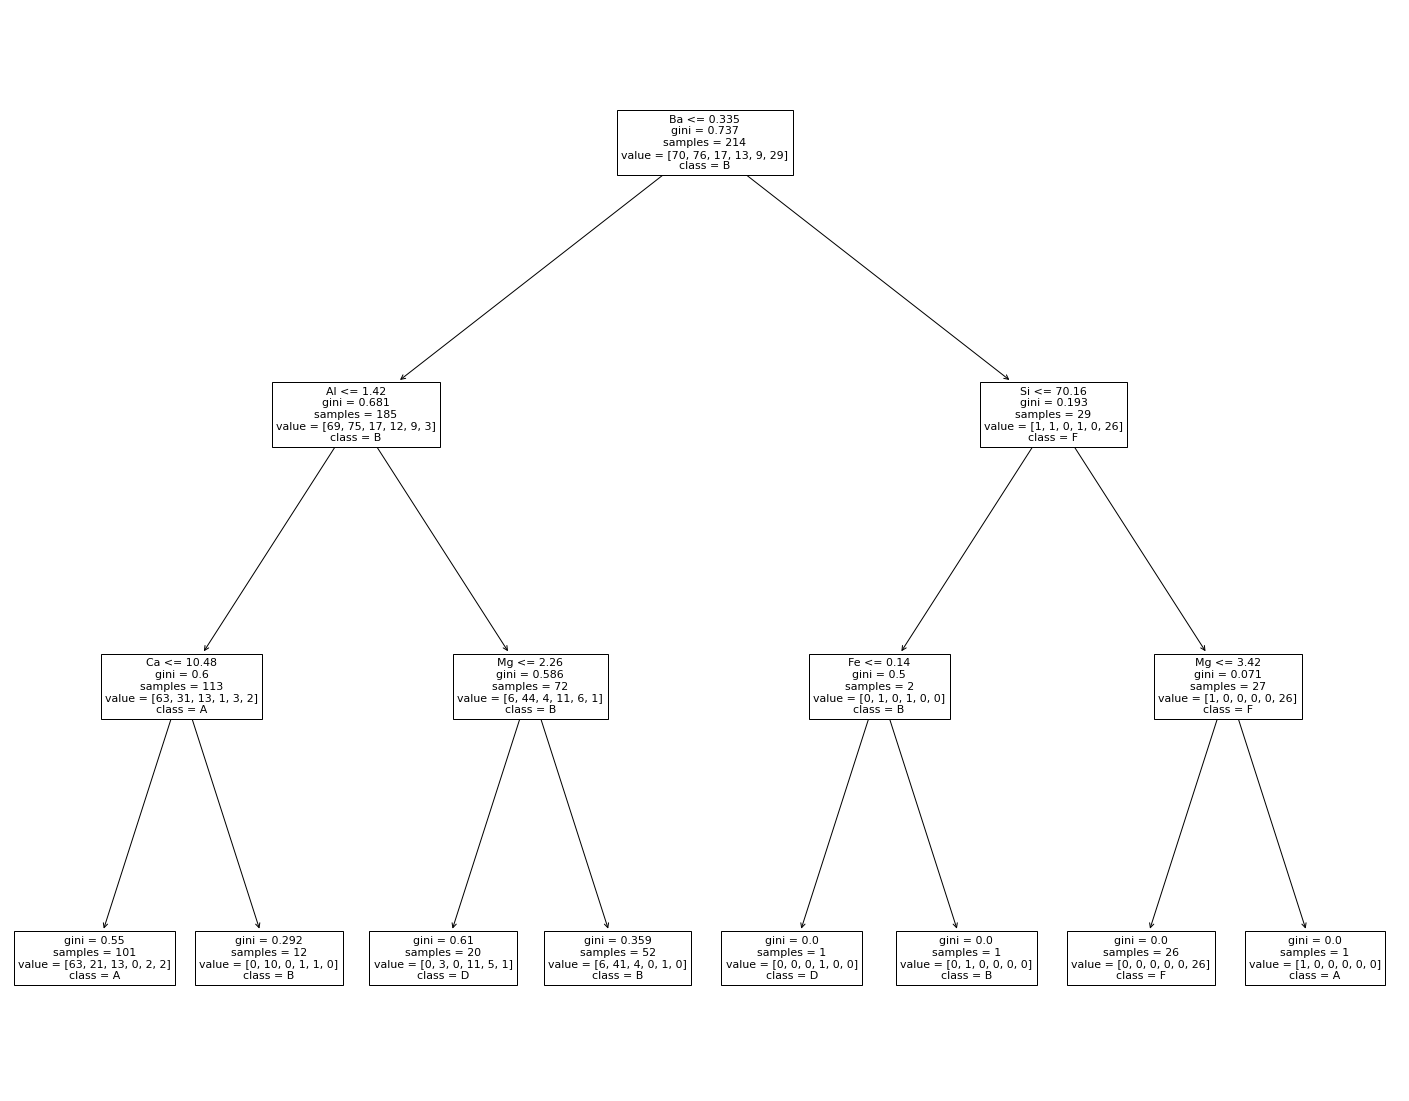

In [3]:
from sklearn import tree
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(25, 20))
tree.plot_tree(model, feature_names=feature_names, class_names=target_names)
fig.savefig('tree.png')
fig.show

In [4]:
!pip install pyDatalog

from pyDatalog import pyDatalog

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
pyDatalog.create_terms('X, Y, label, Mg, Al, Si, Ca, Ba, RI')

In [9]:
(label[X] == 'F')
(label[X] == 'F') <= (Mg[X] <= 3.42)
(label[X] == 'D')
(label[X] == 'D') <= (Si[X] <= 70.16) & (RI[X] <= 1.52)
(label[X] == 'D') <= (Si[X] <= 70.16)
(label[X] == 'D')
(label[X] == 'D') <= (Mg[X] <= 2.26)
(label[X] == 'A')
(label[X] == 'A') <= (Ba[X] <= 0.34) & (Al[X] <= 1.42) & (Ca[X] <= 10.48)
(label[X] == 'A') <= (Ba[X] <= 0.34) & (Al[X] <= 1.42)
(label[X] == 'A') <= (Ba[X] <= 0.34)
(label[X] == 'F')
(label[X] == 'F') <= (Mg[X] <= 3.42)
(label[X] == 'D')
(label[X] == 'D') <= (Si[X] <= 70.16) & (RI[X] <= 1.52)
(label[X] == 'D') <= (Si[X] <= 70.16)
(label[X] == 'D')
(label[X] == 'D') <= (Mg[X] <= 2.26)
(label[X] == 'A')
(label[X] == 'A') <= (Ba[X] <= 0.34) & (Al[X] <= 1.42) & (Ca[X] <= 10.48)
(label[X] == 'A') <= (Ba[X] <= 0.34) & (Al[X] <= 1.42)
(label[X] == 'A') <= (Ba[X] <= 0.34)

label[1]==(*,X,'A') <= Ba[1]<=(*,X,'0.34')

In [19]:
Mg[0] = 4.49
Al[0] = 1.1
Si[0] = 71.78
Ca[0] = 8.75
Ba[0] = 0.0
Fe[0] = 0.0

In [10]:
from joblib import dump

dump(model, 'tree.joblib')

from joblib import load
import sklearn

model = load('tree.joblib')
classes = model.classes_
tree = model.tree_

n_nodes = tree.node_count
children_left = tree.children_left
children_right = tree.children_right
feature = tree.feature
threshold = tree.threshold
value = tree.value

In [11]:
def get_paths(paths):
    for path in paths:
        left = children_left[path[-1]]
        right = children_right[path[-1]]
        if left != right:
            paths.remove(path)
            paths.append(path + [left])
            #paths.append(path + [right])
            paths.append([right])
            get_paths(paths)
    return paths

paths = [[0]]
paths = get_paths(paths)
paths

[[0, 1, 2, 3], [4], [5, 6], [7], [8, 9, 10], [11], [12, 13], [14]]

In [12]:
rules = []
for path in paths:
    conjuncts = []
    for i in range(len(path)):
        node = path[i]
        if node == path[-1]:
            samples = list(value[node][0])
            label = samples.index(max(samples))
        else:
            conjunct = {'feature': feature[node], 
                       'threshold': round(threshold[node], 2)}
            child = path[i + 1]
            if child in children_left:
                conjunct['comparison'] = '<='
            else:
                conjunct['comparison'] = '>'
            conjuncts.append(conjunct)
    rules.append({'label': label, 'conjuncts': conjuncts})

rules

[{'label': 0,
  'conjuncts': [{'feature': 7, 'threshold': 0.34, 'comparison': '<='},
   {'feature': 3, 'threshold': 1.42, 'comparison': '<='},
   {'feature': 6, 'threshold': 10.48, 'comparison': '<='}]},
 {'label': 1, 'conjuncts': []},
 {'label': 3,
  'conjuncts': [{'feature': 2, 'threshold': 2.26, 'comparison': '<='}]},
 {'label': 1, 'conjuncts': []},
 {'label': 3,
  'conjuncts': [{'feature': 4, 'threshold': 70.16, 'comparison': '<='},
   {'feature': 8, 'threshold': 0.14, 'comparison': '<='}]},
 {'label': 1, 'conjuncts': []},
 {'label': 5,
  'conjuncts': [{'feature': 2, 'threshold': 3.42, 'comparison': '<='}]},
 {'label': 0, 'conjuncts': []}]

In [13]:
from sklearn import datasets

def format_name(name):
    name = str(name)
    name = name.replace(' ', '_')
    name = name.replace('(', '')
    name = name.replace(')', '')
    return name

feature_names = [format_name(x) for x in feature_names]
target_names = [f"'{x}'" for x in target_names]

In [14]:
tmplts = []
for rule in rules:
    label = target_names[rule['label']]
    tmplt_label = f'(label[X] == {label})'
    conjuncts = rule['conjuncts']
    if conjuncts:
        conditions = []
        for conjunct in conjuncts:
            feature_name = feature_names[conjunct['feature']]
            conditions.append(f'({feature_name}[X] {conjunct["comparison"]} {conjunct["threshold"]})')
            tmplt_condition = ' & '.join(conditions)
            tmplts.append(f'{tmplt_label} <= {tmplt_condition}')
        else:
            tmplts.append(tmplt_label)

tmplts

["(label[X] == 'A') <= (Ba[X] <= 0.34)",
 "(label[X] == 'A') <= (Ba[X] <= 0.34) & (Al[X] <= 1.42)",
 "(label[X] == 'A') <= (Ba[X] <= 0.34) & (Al[X] <= 1.42) & (Ca[X] <= 10.48)",
 "(label[X] == 'A')",
 "(label[X] == 'D') <= (Mg[X] <= 2.26)",
 "(label[X] == 'D')",
 "(label[X] == 'D') <= (Si[X] <= 70.16)",
 "(label[X] == 'D') <= (Si[X] <= 70.16) & (Fe[X] <= 0.14)",
 "(label[X] == 'D')",
 "(label[X] == 'F') <= (Mg[X] <= 3.42)",
 "(label[X] == 'F')"]

In [15]:
feature_indices = [x for x in set(feature) if x>= 0]
print(feature_indices)
print(feature_names)
predicates = ', '.join([feature_names[x] for x in feature_indices])
print('X, Y, label, ' + predicates)
pyDatalog.create_terms('X, Y, label, ' + predicates)

[2, 3, 4, 6, 7, 8]
['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']
X, Y, label, Mg, Al, Si, Ca, Ba, Fe


In [16]:
tmplts.reverse()
knowledge = """\n""".join(tmplts)
print(knowledge)
pyDatalog.load(""" 
""" +knowledge + """ 
""")
print(knowledge)

(label[X] == 'F')
(label[X] == 'F') <= (Mg[X] <= 3.42)
(label[X] == 'D')
(label[X] == 'D') <= (Si[X] <= 70.16) & (Fe[X] <= 0.14)
(label[X] == 'D') <= (Si[X] <= 70.16)
(label[X] == 'D')
(label[X] == 'D') <= (Mg[X] <= 2.26)
(label[X] == 'A')
(label[X] == 'A') <= (Ba[X] <= 0.34) & (Al[X] <= 1.42) & (Ca[X] <= 10.48)
(label[X] == 'A') <= (Ba[X] <= 0.34) & (Al[X] <= 1.42)
(label[X] == 'A') <= (Ba[X] <= 0.34)
(label[X] == 'F')
(label[X] == 'F') <= (Mg[X] <= 3.42)
(label[X] == 'D')
(label[X] == 'D') <= (Si[X] <= 70.16) & (Fe[X] <= 0.14)
(label[X] == 'D') <= (Si[X] <= 70.16)
(label[X] == 'D')
(label[X] == 'D') <= (Mg[X] <= 2.26)
(label[X] == 'A')
(label[X] == 'A') <= (Ba[X] <= 0.34) & (Al[X] <= 1.42) & (Ca[X] <= 10.48)
(label[X] == 'A') <= (Ba[X] <= 0.34) & (Al[X] <= 1.42)
(label[X] == 'A') <= (Ba[X] <= 0.34)


In [17]:
x = 0 
row = ekes.iloc[x]
for i in feature_indices:
    fact = f'{feature_names[i]}[{x}] = {row[i]}'
    print(fact)
    exec(fact)

Mg[0] = 4.49
Al[0] = 1.1
Si[0] = 71.78
Ca[0] = 8.75
Ba[0] = 0.0
Fe[0] = 0.0


In [18]:
print(pyDatalog.ask('label[X] == Y'))

{(0, 'A')}
